**You are viewing the RISE presentation version of this material. For a conventional Jupyter notebook with more descriptive text, please refer to the master branch at https://github.com/pafoster/path_signatures_introduction**.

In [8]:
import itertools

from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.animation
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
import pandas as pd
import scipy, scipy.interpolate
import sqlite3

import IPython.display

%matplotlib inline

default_figure_height = 8
matplotlib.rcParams['figure.figsize'] = [default_figure_height * scipy.constants.golden_ratio, default_figure_height]
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['figure.titlesize'] = 16
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['legend.title_fontsize'] = 16

# [k for k in matplotlib.rcParams.keys() if 'size' in k]

# An Introduction to Path Signatures - A Data Scientist's Perspective

### Peter Foster
#### The Alan Turing Institute

## Introduction
* Path signatures are fixed-length feature vectors which we may for example use to represent multi-dimensional time series, where samples in the time series need not be evenly spaced in time (**data streams**)
* Path signature features have been applied successfully to human action recognition (Yang et al., 2017), character recognition (Diehl, 2013; Graham, 2013), handwriting recognition (Yin et al., 2013), financial time series classification (Gyurkó et al., 2013), classification of medical disorders and conditions (Arribas et al., 2018; Morrill et al., 2019), crop yield prediction (Lemercier et al., 2020)
* Path signatures may be incorporated readily as features into neural networks
* Path signatures are (in principle) interpretable

## Paths and Streams

## Paths
* A path is a function which maps an interval onto $N$-dimensional Euclidean space
* Consider the path $f(t) = (t-1)^3, t \in [0, 2]$ which we interpret as a function of time
* This is an example of a path with dimensionality $N=1$

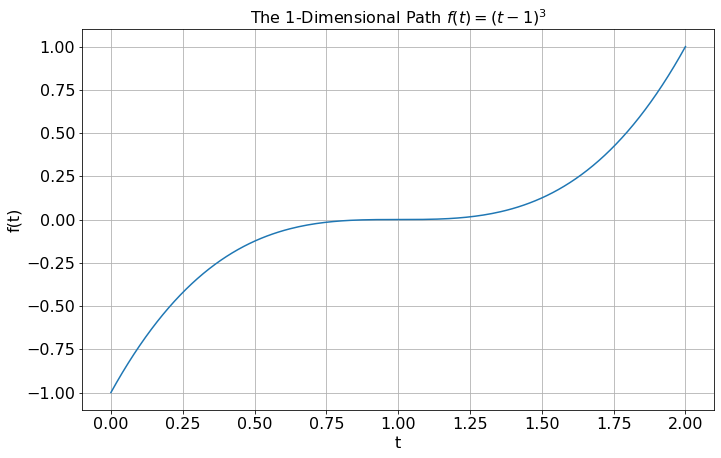

In [9]:
f = lambda t: (t - 1)**3
t = np.linspace(0, 2, 200)

plt.figure(figsize=[7 * scipy.constants.golden_ratio, 7])
plt.plot(t, f(t))
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('The 1-Dimensional Path $f(t) = (t-1)^3$')
plt.grid()
plt.show()

## Paths - II

* In fact, many practical applications of paths involve time as the domain
* Consider a person writing the digit '2' on a touchscreen (Corr et al., 2017)

In [10]:
# Read data corresponding to a single glyph entry, for a given user
conn = sqlite3.connect('data/corr_numeral_gesture_dataset/database.sqlite')
df = pd.read_sql_query("SELECT zglyph.zindex, zglyph.zsubject, zglyph.zcharacter, zglyph.zduration, "
                       "ztouch.ztimestamp, ztouch.zx, ztouch.zy "
                       "FROM zglyph, zstroke, ztouch "
                       "WHERE zstroke.zglyph=zglyph.z_pk AND ztouch.zstroke=zstroke.z_pk "
                       "AND zglyph.zsubject=1 AND zglyph.zcharacter=2;", conn)

df = df[df['ZINDEX'] == df['ZINDEX'].unique()[2]]
df = df[['ZTIMESTAMP', 'ZX', 'ZY']].set_index('ZTIMESTAMP', drop=True).sort_index()

# Process the data for playback
PLAYBACK_SPEED = 0.33
df.index = df.index / PLAYBACK_SPEED
FRAME_RATE=40
t = np.arange(df.index.min(), df.index.max(), 1/FRAME_RATE)
df = df.reindex(df.index.union(t)).interpolate().loc[t]

# Set up the plotplt.figure()
fig, ax = plt.subplots(figsize=[7 * scipy.constants.golden_ratio, 7])
ax.set_xlim(0, 300)
ax.set_ylim(400, 0)
ax.set_xlabel('x(t)')
ax.set_ylabel('y(t)')
ax.set_title('The 2-Dimensional Path $\mathbf{g}(t) = (x(t), y(t))$\n'
             'for a person drawing the digit "2" on a touchscreen')
ax.grid()
line_plot, = ax.plot([],[], alpha=0.15)
scatter_plot = ax.scatter([], [], color='k')
text_box = ax.text(250, 50, '', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Animate the plot
def animate(i):
    selected_data = df.iloc[:int(i+1)]
    line_plot.set_data(selected_data['ZX'], selected_data['ZY'])
    scatter_plot.set_offsets(selected_data[['ZX', 'ZY']].iloc[i])
    text_box.set_text('t={:.1f}s'.format(df.index[i]))
anim = matplotlib.animation.FuncAnimation(fig, animate, len(df), interval=1000/FRAME_RATE)

plt.close(fig)
IPython.display.HTML(anim.to_jshtml())

## Paths - III
* The preceding is an example of a 2-dimensional path $\mathbf{g}(t) = (x(t), y(t))$, where $x(t)$ and $y(t)$ respectively represent the horizontal and vertical screen position at time $t$
* $x(t)$ and $y(t)$ are themselves one-dimensional paths
* **Note:** If we want to ensure that we retain all timing information in our visualisations, we require N+1 dimensions to describe the trajectory of an N-dimensional path, because we need to include the path's domain.

## Streams
* Whereas we typically deal with data sampled at discrete times, the domain of a path is continuous
* We define an $N$-dimensional **data stream** as a sequence of points in $N$-dimensional Euclidean space which we observe at discrete times $t_1<t_2 <\ldots< t_M$
* To obtain a path from a data stream, it is necessary that we interpolate between successive points

## Definition of a Path
* Having considered two examples of paths and their relation to data streams, henceforth we will assume that our paths are piecewise differentiable.
* This assumption is sufficient to allow us to define the path signature (Chen, 1958; Lyons, 1998) as a series of iterated integrals.

We will use capital letters to denote paths: We define an $N$-dimensional path as the mapping $X: [a, b] \to \mathbb{R}^N$. Furthermore, we will use the notation $X_t = X(t)$ to denote the dependence of $X$ on $t \in [a, b]$.

*Side remark*: The preceding examples which we considered are all piecewise differentiable. By contrast, rough path theory (Lyons, 1998) deals with the case where this assumption does not hold, due to the path being highly irregular, as encountered for example in some types of stock prices. (A formal definition of the amount of irregularity in a function is its $p$-variation). A key contribution of rough path theory is that for such paths it is still possible to obtain the path signature in a well-defined sense.

## Path Integrals

## Path Integrals
Given 1-D paths $X_t, Y_t$ and defining $X'_t = dX_t/dt$, we define the path integral
$$\int_a^b Y_t \, X'_t \, dt := \int_a^b Y_t \, dX_t.$$

We can interpret the path integral as the area that we obtain when plotting $Y_t$ against $X_t$ for $t$ in the interval $[a, b]$.

## Properties of Path Integrals
### Translation Invariance
The path integral integral $\int_a^b Y_t \, dX_t$ is invariant to shifting the entire path $X_t$:
$$
\int_a^b Y_t \, dX_t = \int_a^b Y_t \, dZ_t
$$
where $Z_t := X_t + c$ and $c$ is some constant.

## Properties of Path Integrals
### Reparametrisation Invariance
* For the path integral $\int_a^b Y_t \, dX_t$, reparametrisation invariance means that the value of the path integral is invariant to the (instantaneous) speed at which $X_t$ is traced.
* This property relates to the fact that instead of integrating with respect to $t$, in the above equation we integrate with respect to the  path $X_t$.

## Path Integrals as Paths
* We may treat the path integral itself as a path whose domain is the upper limit (or analogously the lower limit) of the integral
* That is, given paths $X_t$ and $Y_t$ with $t \in [a, b]$, we may define the path $Z_c$ with $c \in [a, b]$,
$$ Z_c := \int_a^c Y_t \, dX_t.$$
* Path integrals are in fact the 'building blocks' of the path signature, which we are now ready to introduce...

## Path Signatures

## Path Signatures 
* The signature of an $N$-dimensional path is an ordered set comprising all possible path integrals that we can construct involving combinations of the path's individual 1-dimensional coordinate paths
* Let's consider the $N$-dimensional path $X_t, t \in [a, b]$
* We will use the superscript notation $X_t = (X_t^1, \ldots, X_t^N)$ to denote the 1-dimensional coordinate paths which comprise $X$
* We will assume that each coordinate path is measured in 1-dimensional units, e.g. distance units

## Path Signatures - II
* To obtain the path signature, using path integrals we first obtain the increments of $X^1, \ldots, X^N$ over the interval $[a, t]$ with $t \in [a, b]$, which we denote using $S(X)^1_{a, t}, \ldots, S(X)^N_{a, t}$, 
$$
S(X)^n_{a, t} :=  \int_a^{t} dX^n_c.
$$
* Based on our preceding assumptions, these first order integrals are each quantified in 1-dimensional units. As was mentioned previously, we may interpret $S(X)^n_{a, t}$ itself as a path.

## Path Signatures - III
* We next obtain those integrals involving two paths, with one path a coordinate path $X^m_t$ and the other path the increment $S(X)^n_{a, t}$ of the coordinate path $X_t^n$
* These path integrals are quantified using 2-dimensional units, for example area units
* There are $N^2$ such second order integrals, which we denote using $S(X)^{1,1}_{a, t} \ldots, S(X)^{N,N}_{a, t}$,
$$
S(X)^{n,m}_{a, t} := \int_a^t S(X)^n_{a, c} \, dX^m_c.
$$
* We may interpret these second order integrals as the area that we obtain when plotting $S(X)^n_{a, c}$ against $X^m_c$ over the interval $[a, t]$ and with $t \in [a, b]$.

## Path Signatures - IV
* The set of first order integrals (comprising $N$ integrals) and the set of second order integrals (comprising $N^2$ integrals) are in fact the first and second levels of the **path signature**
* Continuing the process of obtaining path integrals iteratively, there are $N^k$ possible integrals of order $k$ which together form the $k$th level of the path signature
* We use the multi-index $i_1, \ldots, i_k$ to refer to the $k$th order path integral $S(X)^{i_1, \ldots, i_k}_{a, t}$,
$$
S(X)^{i_1, \ldots, i_k}_{a, t} := \int_a^t S(X)^{i_1, \ldots, i_{k-1}}_{a, c} \, dX^{i_k}_c.
$$

## Path Signatures - V
* The path signature $S(X)_{a,b}$ is the **infinite** ordered set of terms that we obtain by considering all levels $k \geq 0$ and with respect to the path's domain $[a, b]$: 
$$
S(X)_{a,b} := (1, S(X)^1_{a, b}, S(X)^2_{a, b}, \ldots, S(X)^N_{a, b},\\
               S(X)^{1, 1}_{a, b}, S(X)^{1, 2}_{a, b}, \ldots, S(X)^{N, N}_{a, b},\\
               S(X)^{1, 1, 1}_{a, b}, \ldots)
$$

* The initial term is $1$ by convention, corresponding to the zeroth level
* In practice, we obtain a **finite number** of terms by truncating the signature after a specified level $K$.

## Path Signatures - VI

* Because the path signature consists of iterated path integrals, it inherits their properties of **translation invariance** and **reparametrisation invariance**
* For applications such as handwriting recognition, where we do not care about the absolute position or speed at which a path is executed, both translation invariance and reparametrisation invariance are useful properties
* However, should we require the path signature to be sensitive to translation and/or reparametrisation, there are transformations that we can apply as a pre-processing step

## The Signature of a Stream
* Recall that a path are continuous mappings, but in practice we deal with data streams
* A stream is a sequence of points $\hat{X}=(x_1, \ldots, x_M)$ with each $x_i \in \mathcal{R}^N$ and with corresponding observation timestamps $a = t_1 < t_2 <\ldots < t_M = b$
* We will use the notation $\hat{X}[i] = x_i$ to denote the dependence of $\hat{X}$ on discrete observations
* To obtain the signature of $\hat{X}$, we first obtain the $N$-dimensional path $X: [a,b] \to \mathcal{R}^N$ by interpolating between successive points in $\hat{X}$, so that $X_{t_i} = \hat{X}[i]$
* We then compute the signature of the interpolated path $S(X)_{a,b}$



## The Signature of a Stream - II
* The signature of a stream depends on our choice of interpolation method
* Because the signature is invariant to path reparametrisation, we may set the stream's observation timestamps to an arbitrary strictly increasing sequence
* For this reason, besides the sequence of points $(x_1, \ldots, x_M)$ we need not supply timestamp information when visualising a stream or computing its signature


## Stream Transformations

## Stream Transformations
* The signature $S(X)$ of the path $X_t$ is invariant to reparametrisation with respect to $t$
* In addition, the signature is translation-invariant with respect to $X$.
* Both are useful properties for applications such as hand-written digit or post recognition, where we do not necessarily care about the speed at which a path is executed and its position in relation to the origin.
* However, it is possible to apply a variety of transformations to streams which endow the signature with greater power
* For example, a given application might require that the signature is sensitive to reparametrisation and/or translation
* It is possible to satisfy those particular requirements using appropriate transformations, which we apply to our streams as a pre-processing step

That is, rather than compute the signature $S(X)_{a,b}$, we compute the signature $S(T)_{a,b}$ where $T$ is the path that we interpolate after transforming our input stream $\hat{X}$ to the stream $\hat{T}$. In this way, we modify the properties and behaviour of the signature taken as a function of $X$. The following section provides an non-exhaustive overview of transformations.

## The Time-Integrated Transformation
* Besides being invariant to reparametrisation and translation, it turns out that the signature is invariant to retracing of path segments, as might for example arise from periodic movement (clapping, walking etc.)
* To ensure signature uniqueness up to path translation, it is sufficient to transform the path $X$ to include a strictly increasing coordinate path
* Thus, we can make use of the **time-integrated transformation** when the speed of executing a path is relevant to our application

### The Time-integrated Transformation
The following figure displays the effect of applying the time-integrated transformation to stream $\hat{W}$ as previously defined, based on plotting $\hat{T}^3_{\text{time}}(\hat{W})$ against $\hat{T}^2_{\text{time}}(\hat{W})$ and $\hat{T}^1_{\text{time}}(\hat{W})$:

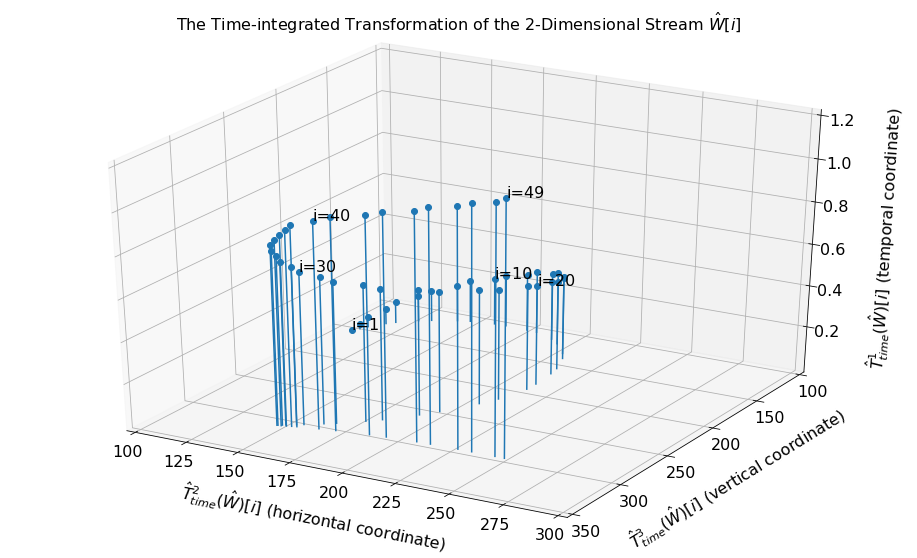

In [11]:
time_integrated_transformation = lambda t_i, W_i: np.vstack((t_i, W_i))

figure_height=10.0
fig = plt.figure(figsize=(figure_height * scipy.constants.golden_ratio, figure_height))
ax = fig.add_subplot(111, projection='3d')

def plot_stem3d(x, y, z, ax):
    for i, (xi, yi, zi) in enumerate(zip(x, y, z)):        
        line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), marker='o', markevery=(1, 1))
        ax.add_line(line)

        if i == 0 or i == len(x) - 1 or (i+1) % 10 == 0:
            ax.text(xi, yi, zi, 'i={}'.format(i+1))

W_i = np.array(df[['ZX', 'ZY']]).T
t_i = df.index

T_time = time_integrated_transformation(t_i, W_i)
plot_stem3d(x=T_time[1],
            y=T_time[2],
            z=T_time[0],
            ax=ax)

ax.set_xlabel('$\hat{T}^2_{time}(\hat{W})[i]$ (horizontal coordinate)', fontsize=16, labelpad=20)
ax.set_ylabel('$\hat{T}^3_{time}(\hat{W})[i]$ (vertical coordinate)', fontsize=16, labelpad=20)
ax.set_zlabel('$\hat{T}^1_{time}(\hat{W})[i]$ (temporal coordinate)', fontsize=16, labelpad=20)
plt.title('The Time-integrated Transformation of the 2-Dimensional Stream $\hat W[i]$',
          fontsize=16, pad=20)
ax.set_xlim3d(100, 300)
ax.set_ylim3d(350, 100)
ax.set_zlim3d(min(t_i), max(t_i))

plt.grid()
plt.show()

## The Invisibility Reset Transformation
* The signature of a path is invariant to path translation
* For the case where we require translation sensitivity for the stream $\hat{X} =(x_1, \ldots, x_M)$, the **invisibility reset transformation** (Wu et al., 2020) appends two points $x_{M+1} = x_M$ and $x_{M+2} = \mathbf{0}$, in addition to a binary-valued coordinate stream:
$$
\hat{T}_{\text{inv-reset}}(\hat{X}) = ((x_1, 0), \ldots, (x_M, 0), (x_{M+1}, 1), (x_{M+2}, 1)).
$$
* From the perspective of the interpolated path, the invisibility reset transformation is akin to drawing with a 'pen' on a flat sheet of paper, then lifting the pen to unit height and returning it to an 'ink well' with unit height placed at the origin

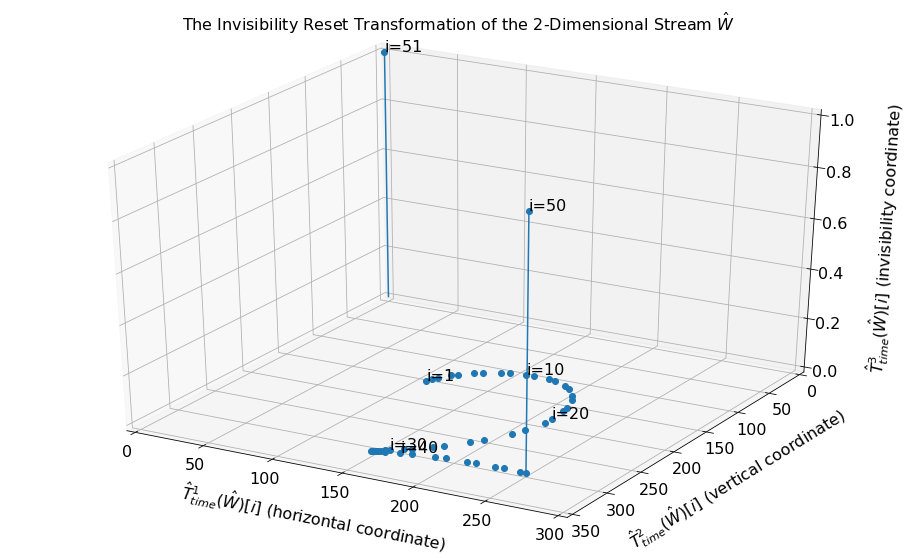

In [12]:
def invisibility_reset_transformation(W_i):
    W_i = np.hstack((W_i, W_i[:, -1:]))
    W_i = np.hstack((W_i, np.zeros((2, 1))))
    invisibility_indicator = np.zeros(W_i.shape[1])
    invisibility_indicator[-2:] = 1
    
    return np.vstack((W_i, invisibility_indicator))

figure_height=10.0
fig = plt.figure(figsize=(figure_height * scipy.constants.golden_ratio, figure_height))
ax = fig.add_subplot(111, projection='3d')

W_i = np.array(df[['ZX', 'ZY']]).T
t_i = df.index

T_time = invisibility_reset_transformation(W_i)
plot_stem3d(x=T_time[0],
            y=T_time[1],
            z=T_time[2],
            ax=ax)

ax.set_xlabel('$\hat{T}^1_{time}(\hat{W})[i]$ (horizontal coordinate)', fontsize=16, labelpad=20)
ax.set_ylabel('$\hat{T}^2_{time}(\hat{W})[i]$ (vertical coordinate)', fontsize=16, labelpad=20)
ax.set_zlabel('$\hat{T}^3_{time}(\hat{W})[i]$ (invisibility coordinate)', fontsize=16, labelpad=20)
plt.title('The Invisibility Reset Transformation of the 2-Dimensional Stream $\hat W$',
          fontsize=16, pad=20)
ax.set_xlim3d(0, 300)
ax.set_ylim3d(350, 0)
ax.set_zlim3d(0, 1)

plt.grid()
plt.show()

## The Missing Data Transformation
* Stream transformations provide us with an elegant means of dealing with missing data
* Similar to the invisibility reset transformation, one possible approach (Chevyrev and Kormilitzin, 2016) involves incorporating an additional coordinate stream $\hat{Y}=(y_1, \ldots, y_M)$ to indicate the presence of missing data in the stream $\hat{X} = (x_1, \ldots, x_M)$, with $\hat{Y}[i] = 1$ if $\hat{X}[i]$ is marked as missing, $\hat{Y}[i] = 0$ otherwise
* Furthermore, if observation $\hat{X}[i]$ is marked as missing, we replace it e.g. with $\hat{X}[j]$ such that $j < i$ is the largest value for which $\hat{X}[j]$ is not marked as missing

The following figure displays the effect of applying the aforementioned variant of the missing data transformation $\hat{T}_{\text{missing}}$ to stream $\hat{W}$ (representing measurements for the handwritten digit 2). For the plot, we mark every 10th point in $\hat{W}$ as missing. In the plot, the first two dimensions correspond to horizontal and vertical coordinates (with missing observations replaced with their predecessors), whereas the third dimension is the 'data missing' coordinate stream $\hat{Y}$:

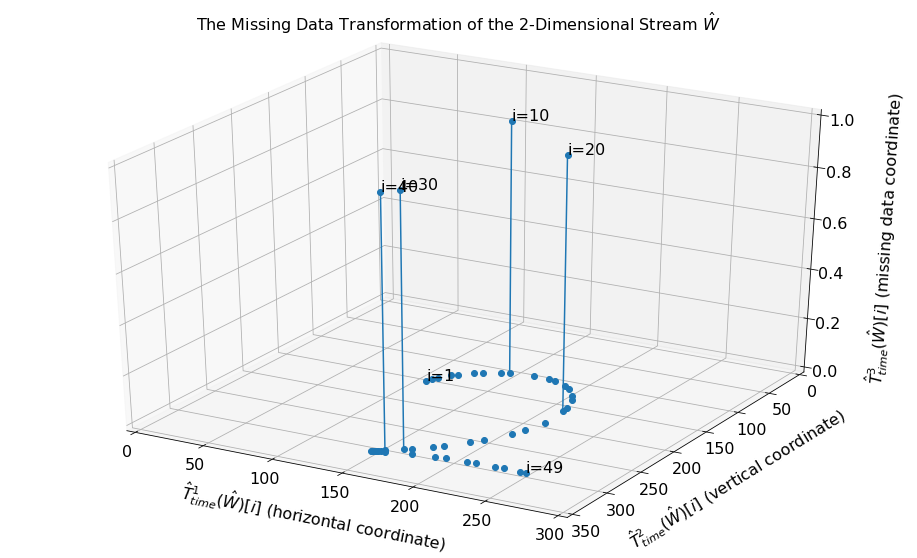

In [13]:
def missing_data_transformation(W_i):
    missing_value_indices = np.array(range(0, W_i.shape[1], 10)[1:], dtype=int) - 1
    # Mark every 10th point as missing
    W_i[:, missing_value_indices] = np.nan
    # Replace missing observations with their predecessors
    W_i[:, missing_value_indices] = W_i[:, missing_value_indices - 1]
    missing_value_mask = np.zeros(W_i.shape[1])
    missing_value_mask[missing_value_indices] = 1
    
    return np.vstack((W_i, missing_value_mask))

figure_height=10.0
fig = plt.figure(figsize=(figure_height * scipy.constants.golden_ratio, figure_height))
ax = fig.add_subplot(111, projection='3d')

W_i = np.array(df[['ZX', 'ZY']]).T
t_i = df.index

T_missing = missing_data_transformation(W_i)
plot_stem3d(x=T_missing[0],
            y=T_missing[1],
            z=T_missing[2],
            ax=ax)

ax.set_xlabel('$\hat{T}^1_{time}(\hat{W})[i]$ (horizontal coordinate)', fontsize=16, labelpad=20)
ax.set_ylabel('$\hat{T}^2_{time}(\hat{W})[i]$ (vertical coordinate)', fontsize=16, labelpad=20)
ax.set_zlabel('$\hat{T}^3_{time}(\hat{W})[i]$ (missing data coordinate)', fontsize=16, labelpad=20)
plt.title('The Missing Data Transformation of the 2-Dimensional Stream $\hat W$',
          fontsize=16, pad=20)
ax.set_xlim3d(0, 300)
ax.set_ylim3d(350, 0)
ax.set_zlim3d(0, 1)

plt.grid()
plt.show()

## Conclusion
* Path signatures are a flexible and powerful means of obtaining fixed-length features from multi-dimensional time series with applications in machine learning
* Path signatures may be applied regardless of whether the time series of interest are evenly spaced in time
* Can modify the properties and behaviour of signatures as required, by applying path transformations as a pre-processing step, possible to account for missing data
* Path signatures are a very activate area of research

## Suggested Starting Points
* Terry Lyons' Rough Paths Group https://datasig.web.ox.ac.uk
* esig (Lyons et al.) https://esig.readthedocs.io/en/latest/
* iisignature (Graham and Reizenstein) https://github.com/bottler/iisignature
* signatory (Kidger) https://signatory.readthedocs.io/en/latest/pages/reference/path.html

# References
Arribas, I.P., Goodwin, G.M., Geddes, J.R., Lyons, T. and Saunders, K.E., 2018. A signature-based machine learning model for distinguishing bipolar disorder and borderline personality disorder. Translational Psychiatry, 8(1), pp.1-7.

Chen, K.T., 1958. Integration of paths--A faithful representation of paths by noncommutative formal power series. Transactions of the American Mathematical Society, 89(2), pp.395-407.

Chevyrev, I. and Kormilitzin, A., 2016. A primer on the signature method in machine learning. arXiv preprint arXiv:1603.03788.

Corr, P.J., Silvestre, G.C. and Bleakley, C.J., 2017. Open source dataset and deep learning models for online digit gesture recognition on touchscreens. arXiv preprint arXiv:1709.06871.

Diehl, J., 2013. Rotation invariants of two dimensional curves based on iterated integrals. arXiv preprint arXiv:1305.6883.

Graham, B., 2013. Sparse arrays of signatures for online character recognition. arXiv preprint arXiv:1308.0371.

Gyurkó, L.G., Lyons, T., Kontkowski, M. and Field, J., 2013. Extracting information from the signature of a financial data stream. arXiv preprint arXiv:1307.7244.

Hambly, B. and Lyons, T., 2010. Uniqueness for the signature of a path of bounded variation and the reduced path group. Annals of Mathematics, pp.109-167.

Lemercier, M., Salvi, C., Damoulas, T., Bonilla, E.V. and Lyons, T., 2020. Distribution regression for continuous-time processes via the expected signature. arXiv preprint arXiv:2006.05805.

Lyons, T.J., 1998. Differential equations driven by rough signals. Revista Matemática Iberoamericana, 14(2), pp.215-310.

Morrill, J., Kormilitzin, A., Nevado-Holgado, A., Swaminathan, S., Howison, S. and Lyons, T., 2019. The signature-based model for early detection of sepsis from electronic health records in the intensive care unit. In 2019 Computing in Cardiology (CinC).

Wu, Y., Ni, H., Lyons, T.J. and Hudson, R.L., 2020. Signature features with the visibility transformation. arXiv preprint arXiv:2004.04006.

Yang, W. and Lyons, T. and Ni, H. and Schmid, C. and Jin, L., 2017. Developing the path signature methodology and its application to landmark-based human action recognition. arXiv preprint arXiv:1707.03993.

Yin, F., Wang, Q.F., Zhang, X.Y. and Liu, C.L., 2013. ICDAR 2013 Chinese handwriting recognition competition. In 2013 12th International Conference on Document Analysis and Recognition (pp. 1464-1470).